In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pickle
from numpy.fft import fftshift,ifft
from scipy.signal import stft, windows
from misc import *

from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [36]:
# 定义稀疏自编码器
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, sparsity_param=0.05, beta=3):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
        self.sparsity_param = sparsity_param  # 稀疏性目标
        self.beta = beta  # KL散度惩罚项的权重

    def forward(self, x):
        hidden = self.encoder(x)
        output = self.decoder(hidden)
        return output, hidden

In [37]:
model_pol = torch.load('SAE_pol.pth');   
model_rcs = torch.load('SAE_rcs.pth');
model_hrrp = torch.load('SAE_hrrp.pth');

model_pol.eval();
model_rcs.eval();
model_hrrp.eval();

In [38]:
dataset_path = 'G:/MRM_0.5/'
train_data_path = dataset_path + 'train/'
test_data_path = dataset_path + 'test/'

def preprocessing(data, snr):
    E_pol = []
    polar_type = ['HH', 'HV', 'VH', 'VV']
    E, noise_power = awgn(data['echo']['HH'], snr=snr)
    for pol in polar_type:
        E, _ = awgnfp(data['echo'][pol], noise_power=noise_power)
        E_pol.append(np.abs(E))
    E_pol = np.array(E_pol).astype(np.float32)       # (4, 512)

    RCS = rcs(E)
    RCS = RCS.astype(np.float32)

    hrrp, noise_power = awgn(data['hrrp']['HH'], snr=snr)
    hrrp = fftshift(ifft(hrrp,axis = 0),axes=0)
    hrrp = np.log10(np.abs(hrrp))
    hrrp = hrrp.astype(np.float32)

    return E_pol, RCS, hrrp

class Dataset(Dataset):
    def __init__(self, dataset_dir, snr, pad_size):
        self.snr = snr
        self.pad_size = pad_size
        self.dataset_dir = dataset_dir
        self.instance_list = self.get_instance()
    
    def get_instance(self):
        instance_list = []
        for label in os.listdir(self.dataset_dir):
            label_dir = os.path.join(self.dataset_dir,label)
            label_list = glob.glob(label_dir+'/*.pkl')
            instance_list += label_list
        return instance_list

    def __len__(self):
        return len(self.instance_list)

    def __getitem__(self, idx):
        data = load_pkl(self.instance_list[idx])
        x = preprocessing(data, snr = self.snr)  
        y = data['target_id']
        return x, torch.tensor(y, dtype=torch.long)

In [45]:
snr = 0
pad_size = 201
train_dataset = Dataset(train_data_path, snr = snr, pad_size = pad_size)
test_dataset = Dataset(test_data_path, snr = snr, pad_size = pad_size)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

inp, label = train_dataset.__getitem__(1)

inp = torch.from_numpy(inp[2]).to(device)
# # 定义稀疏自编码器模型
# input_size = inp.shape[0]*inp.shape[1]  

outputs, hidden = model_hrrp.forward(inp.reshape(1,201*512).to(device))
print(hidden.shape)
torch.max(hidden)

torch.Size([1, 128])


tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)

In [33]:
def normalizenp(z):
    z_max = torch.max(z)
    z_min = torch.min(z)
    
    # 按照公式进行归一化
    z_normalized = ((z - z_max) + (z - z_min)) / (z_max - z_min)
    
    return z_normalized

def gasf(phi):
    """
    Constructs the Gramian Summation Angular Field (GASF) from the angle phi.
    
    :param phi: A tensor of angles (in radians), typically derived from the arccos of normalized values.
    :return: The Gramian Summation Angular Field (GASF) matrix.
    """
    # Expand dimensions to perform outer sum
    phi_i = phi.unsqueeze(1)  # Shape: (n, 1)
    phi_j = phi.unsqueeze(0)  # Shape: (1, n)
    
    # Compute GASF using cosine of angle sums
    gasf_matrix = torch.cos(phi_i + phi_j)
    return gasf_matrix

tensor(0)


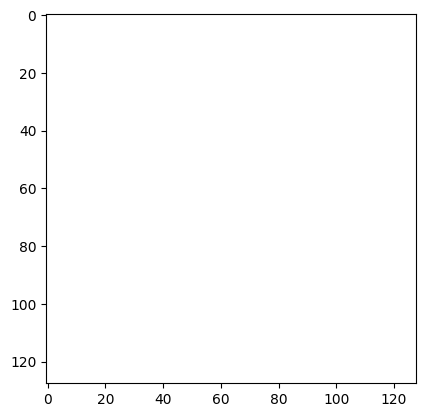

In [34]:
plt.imshow(gasf(normalizenp(hidden.squeeze(0))).detach().cpu().numpy())
print(label)